#**ML Mini project advanced solution**


# 1 Author

**Student Name**:  Nisha Bhat

**Student ID**:  210734432



# 2 Problem formulation

Describe the machine learning problem that you want to solve and explain what's interesting about it.


---



**Basic solution**: Using the MLEnd Hums and Whistles dataset, build a machine learning pipeline that takes as an input a Mamma or a Frozen audio segment and predicts its song label and its interpretation (either Hum of Mamma or Whistle of Mamma or Hum of Frozen or Whistle of Frozen).

In the basic solution, the model was able to predict between 2 different labels. How different would it predict for 4 lables? Would it make sense to create 2 different models, where one would predict hums and whistles and the other Mamma and Frozen?

In this notebook, 2 methods to predict song and interpretation are tried.
1. First method: Use 4 lables - Frozen_Hum, Frozen_Whistle, Mamma_Hum, Mamma_Whistle - and train 1 model to be used for classification.
2. Second method: Use 2 models - one to classify hums and whistles, and the other to classify Frozen and Mamma. Combine the results of both models to answere the problem statement. 

# 3 Machine Learning pipeline

Describe your ML pipeline. Clearly identify its input and output, any intermediate stages (for instance, transformation -> models), and intermediate data moving from one stage to the next. Note that your pipeline does not need to include all the stages. 


---



The workflow for this solution is 
1. Data loading
2. Feature extraction
3. Model development
4. Model performance evaluation

with stages 2 and 3 repeated to find best performing models


 **Data Loading:** 
*   The audio files names have been cleaned so that all files follow the naming convension of 'participationID_interpretation_interpretationID_Songname'. Any files loaded to this pipeline must follow the same convension.
*   The input to this stage is the path where all the hums and whistles to Potter and StarWars is stored. 
*   The method rawdataSet(path) will load all the filenames in the given path to a variable called files which will be used in next 2 stages of the workflow.
*   The output is a list of all the filenames stored in this path.

**Feature Extraction:**
*   Input to this stage is the list of files loaded in the previous stage.
*   In this stage each audio file is loaded for processing using librosa.load function. 
*   The method getFeatures(files) (available in the next section) provides the set of features along with its label y. Since we are classifying among 4 classes, y consists of the song name followed by the interpretation.
*   Outputs of this stage are 2 arrays - one for features (X) abd the other for labels (y).

**Model development:**
*   Input to this stage are the arrays with feature set and labels. 
*   In this stage the extracted features are standarised using method - standardize(X)
*   The featureset and labels are split to training and test datasets using sklearn's train_test_split
*   Then an SVM model and a Random Forest Classification model is built using the split dataset
*   Output to this stage is the trained and validated model.

**Model performance evaluation:**
*   Input to this stage is the model.
*   Accuracy of the model is calculated to check the correctness of the predictions made.
*   Importance given to features by the model is examined for each model 
*   Based on the observations on the weightage for features, if necessary, feature extraction stage can be iterated again with modifications.
*   Output of this stage can either be a decision to iterate with new features and/or models OR the decision of finalising a model for deployment.

A pictorial representation of the workflow and pipeline is as shown below:
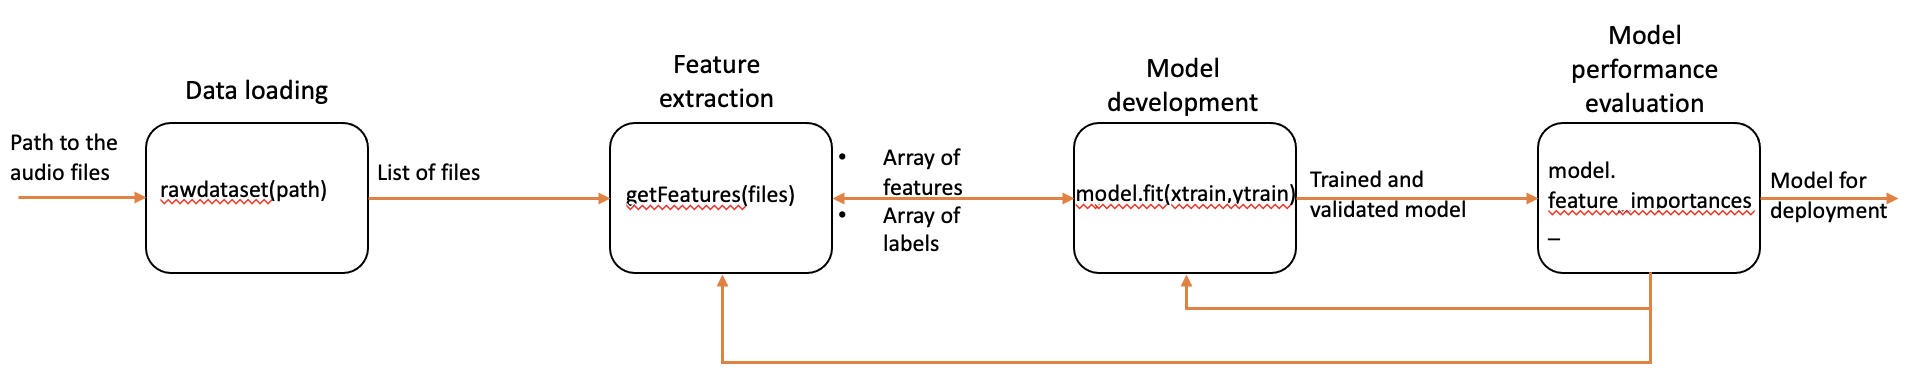

In [1]:
from google.colab import drive

import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
import librosa

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
def rawdataSet(path):
  files = glob.glob(path)
  return files

# 4 Transformation stage

Describe any transformations, such as feature extraction. Identify input and output.


Features used for advanced solution are:

1. Root Mean Square Energy (RMSE)
> *   RMSE calculates the energy (magnitude) of an audio signal. That means RMSE tells us how loud the audio is. 
> *   RMSE is used as a feature to distinguish the difference in the enery among the 4 types of audio.

2. Zero-crossing rate (ZCR)
> *   ZCR is used to differentiate between music, voice and silence. It calculates the rate at which a signal changes between music, voice and silence. 
> *   Potter and Starwars have voice and silence at different timeframes in our audio files which can be used as one of the features.

3. Power spectrum chromagram
> * Power spectrum chromagram creates a vector of 12 equal tempered pitch class.
> * This feature is used to differentiate between the pitches of the 4 types of audio

4. Spectral features
> * Spectral contrast, rolloff, bandwidth and centroid are the 4 spectral features used in this solution
> * Spectral contrast differentiates beween the harmonic and non-harmonic components for each cycle of the waveform in the audio. The mean of the distribution of the difference between harmonic and non-harmonic components is used as a feature.
> * Spectral rolloff also helps differentiate the voiced and non voiced fragments of the audio. 
> * Spectral bandwidth is used to calculate the frequency bandwidth of each cycle of the waveform.
> * Spectral centroid helps find the high frequency content in the audio file.

The output of each feature calculation is array of values for each cycle of the waveform. This solutions uses the mean of the arrays as features.

5. Features from starterkit
> * Features from starter-kit gave good results for hums and whistles classification. They have been re-used for this purpose.



In [112]:
files = rawdataSet('/content/drive/MyDrive/MLDataset/sample/*.wav')
print("Number of audio files in the raw dataset =", len(files))

Number of audio files in the raw dataset = 200


In [25]:
def getPitch(x,fs,winLen=0.02):
  #winLen = 0.02 
  p = winLen*fs
  frame_length = int(2**int(p-1).bit_length())
  hop_length = frame_length//2
  f0, voiced_flag, voiced_probs = librosa.pyin(y=x, fmin=80, fmax=450, sr=fs,
                                                 frame_length=frame_length,hop_length=hop_length)
  return f0,voiced_flag

In [26]:
def getFeatures(files):
  X,c=[],[]
  for file in tqdm(files):
    filename = file.split('/')[-1].split(".")[0]

    #creating labels - True if filename has Potter in it, False if it has starwars
    lab = filename.split('_')[3]+'_'+filename.split("_")[1]

    #Feature extraction
    #Loading the file
    y, sr = librosa.load(file, mono=True, duration=30)
    #Root Mean Square Energy 
    rms = librosa.feature.rms(y=y)
    #Zero-crossing rate 
    zcr = librosa.feature.zero_crossing_rate(y)
    #Power spectrum chroma
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    #Spectral contrast 
    contrast = librosa.feature.spectral_contrast(y=y,sr=sr)
    #Spectral rolloff
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    #Spectral bandwidth
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    #Spectral centroid
    spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)

    #features from starter kit
    f0, voiced_flag = getPitch(y,sr,winLen=0.02)
    power = np.sum(y**2)/len(y)
    pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
    pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
    voiced_fr = np.mean(voiced_flag)

    
    xi = [np.mean(rms),np.mean(zcr),np.mean(chroma_stft),np.mean(contrast),np.mean(rolloff),np.mean(spec_bw),np.mean(spec_cent),power,pitch_mean,pitch_std,voiced_fr]
    X.append(xi)
    c.append(lab)

  return np.array(X),np.array(c)

In [27]:
X,y = getFeatures(files)

100%|██████████| 200/200 [11:27<00:00,  3.44s/it]


# 5 Modelling

Describe the ML models that you will implement. 


---



After experimenting with different algorithms, random forest classifier proved to be most accurate. 

Random forest classification is an ensemble of multiple decision trees. This classifier was used to classify 200 audio files among 4 lables based on 10 features.

This algorithm was chosen due to its ability to use the outputs of multiple decision trees which inturn use different subsets of featureset. i.e The model learns by splitting the featuresets into many combination.
Since Random forest picks the output from most picked lables, the model is overfit - the training accuracy is 100%. The validation accuracy however is not great.

Upon examining the feature importance, on contrary to what was observed in the basic solution, the model has weighted pitch and voice frequency high whereas spectral frequencies that proved to be important in the basic solution are weighted low.
This could be due to the imbalance in the dataset. Whistles type of audio files are much lower compared to hum type of files. Correcting this may help improve the accuracy.


In [28]:
#Standardisind the feature set
def standardize(X):
  scaler = StandardScaler()
  X = scaler.fit_transform(X)
  return X

In [29]:
X = standardize(X)

In [30]:
#Splitting the dataset into 80% train and 20% test
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2)

In [58]:
#Random Forest classifier model
model_rf=RandomForestClassifier()
model_rf.fit(X_train,y_train)
yt_p = model_rf.predict(X_train)
yv_p = model_rf.predict(X_val)
print('Training Accuracy', np.mean(yt_p==y_train))
print("Validation Accuracy:",metrics.accuracy_score(y_val,yv_p))


Training Accuracy 1.0
Validation Accuracy: 0.625


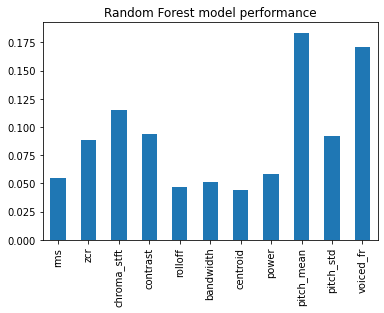

In [88]:
#Random Forest model performance
feature_headers = ['rms','zcr','chroma_stft','contrast','rolloff','bandwidth','centroid','power','pitch_mean','pitch_std','voiced_fr']
pd.Series(model_rf.feature_importances_, index = feature_headers).plot(kind='bar', title='Random Forest model performance')

To use this model for any new file, model_rf must be used for predicting. 

In [70]:
new_file = ['/content/drive/MyDrive/MLDataset/input/S1_Hum_2_Mamma.wav']

In [71]:
new_X,new_y = getFeatures(new_file)

100%|██████████| 1/1 [00:04<00:00,  4.07s/it]


In [72]:
new_X = standardize(new_X)

In [77]:
pred = model_rf.predict(new_X)
print("The audio file is", pred)
print("Accuracy of prediction is",metrics.accuracy_score(new_y,pred))

The audio file is ['Mamma_Hum']
Accuracy of prediction is 1.0


# 7 Dataset

Describe the dataset that you will use to create your models and validate them. If you need to preprocess it, do it here. Include visualisations too. You can visualise raw data samples or extracted features.

In [85]:
(label, count) = np.unique(y, return_counts=True)
for i in range(len(label)):
  print(' The number of {0} recordings in the dataset is {1}'.format(label[i],count[i]))


 The number of Frozen_Hum recordings in the dataset is 81
 The number of Frozen_Whistle recordings in the dataset is 19
 The number of Mamma_Hum recordings in the dataset is 80
 The number of Mamma_Whistle recordings in the dataset is 20


The features are non correlated - this contributes positively to our model as there are no redundant features. 

On close observation, spectral bandwidth and spectral rolloff and spectral centroid seem to be correlated - this could be because rolloff computes voice and slilence in the same bandwidth - i.e it is frequency below certain percentile.
Thus both these could have same values for some cycles of the waveform

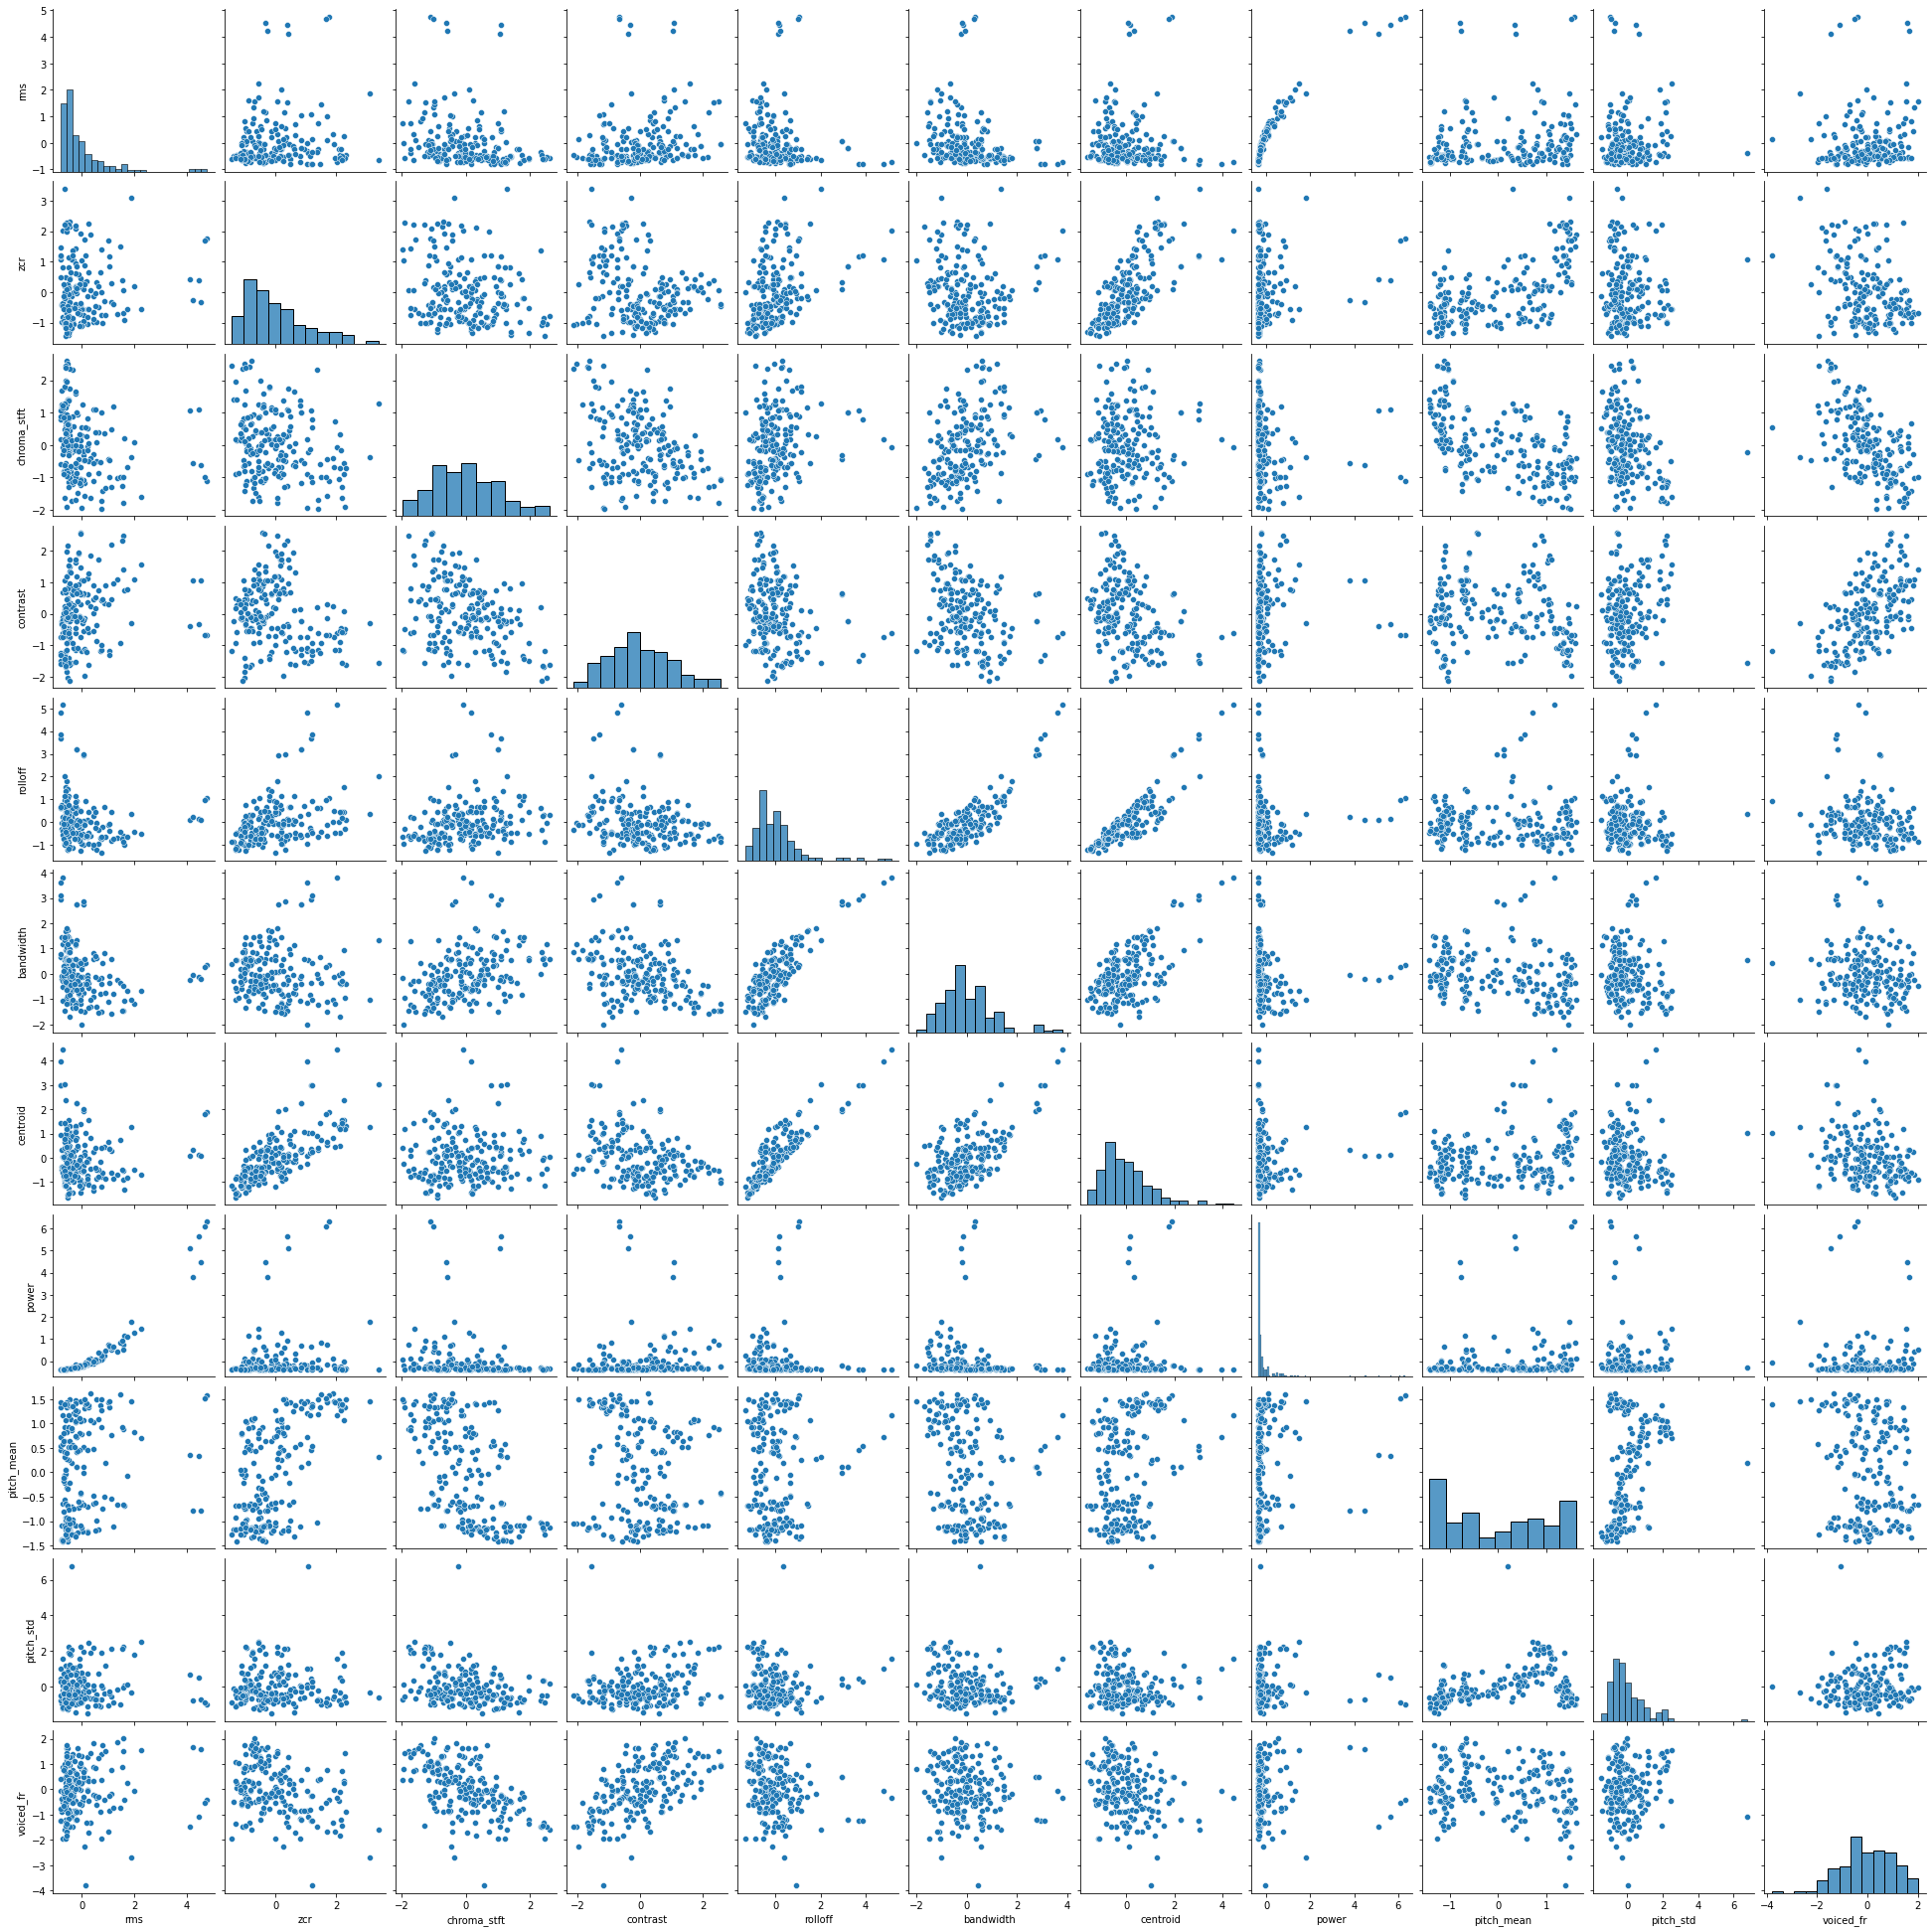

In [86]:
featureSet = pd.DataFrame(X, columns = feature_headers)
sns.pairplot(featureSet)

# 8 Results

Carry out your experiments here, explain your results.


---



Based on the observations made in the starter kit and basic solution, multiple combinations of the 10 features were used to experiment with. 

1. SVM and Randomforest algorithms were used to identify model with better accuracy.
>* Without a linear kernal, the training accuracy was 99.25% - clear overfitting. Linear kernel can be used to avoid overfitting the model.
>* The model performed poorly, unable to classify among the 4 effectively. 
>* This could be due to the size of the dataset. The dataset is imbalenced between the 4 lables.

2. Experimenting by creating 2 models as described in the problem formulation
> 1. Classifying hums and whistles
> 2. Classifying frozen and mamma

The results from both these models were merged to comapre it with the above randrom forest model (in section 5) that classfied among 4 different labels.


In [87]:
#SVM model without linear kernel
model_svm  = svm.SVC(C=1,gamma=2)
model_svm.fit(X_train,y_train)
yt_p = model_svm.predict(X_train)
yv_p = model_svm.predict(X_val)
print('Training Accuracy', np.mean(yt_p==y_train))
print("Validation Accuracy:",metrics.accuracy_score(y_val,yv_p))

Training Accuracy 0.99375
Validation Accuracy: 0.45


In [111]:
def humAndWhistle(files):
  X,c=[],[]
  for file in tqdm(files):
    filename = file.split('/')[-1].split(".")[0]
    #creating labels - True if filename has Potter in it, False if it has starwars
    lab = filename.split('_')[1]=='Hum'
    #Feature extraction
    #Loading the file
    y, sr = librosa.load(file, mono=True, duration=30)
    #features from starter kit
    f0, voiced_flag = getPitch(y,sr,winLen=0.02)
    power = np.sum(y**2)/len(y)
    pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
    pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
    voiced_fr = np.mean(voiced_flag)

    xi = [power,pitch_mean,pitch_std,voiced_fr]
    X.append(xi)
    c.append(lab)

  return np.array(X),np.array(c)

In [101]:
def mammaAndFrozen(files):
  X,c=[],[]
  for file in tqdm(files):
    filename = file.split('/')[-1].split(".")[0]

    #creating labels - True if filename has Potter in it, False if it has starwars
    lab = filename.split('_')[3]=='Frozen'

    #Feature extraction
    #Loading the file
    y, sr = librosa.load(file, mono=True, duration=30)
    #Root Mean Square Energy 
    rms = librosa.feature.rms(y=y)
    #Power spectrum chroma
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    #Spectral contrast 
    contrast = librosa.feature.spectral_contrast(y=y,sr=sr)
    #Spectral rolloff
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    #Spectral bandwidth
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    #Zero-crossing rate 
    zcr = librosa.feature.zero_crossing_rate(y)
    
    xi = [np.mean(rms),np.mean(chroma_stft),np.mean(contrast),np.mean(rolloff),np.mean(spec_bw),np.mean(zcr)]
    X.append(xi)
    c.append(lab)

  return np.array(X),np.array(c)

In [113]:
humF,humL = humAndWhistle(files)

100%|██████████| 200/200 [10:30<00:00,  3.15s/it]


In [114]:
humF = standardize(humF)

In [116]:
X_train_hum, X_val_hum, y_train_hum, y_val_hum = train_test_split(humF,humL,test_size=0.2)

In [117]:
model_hw=RandomForestClassifier()
model_hw.fit(X_train_hum,y_train_hum)
yt_p_hum = model_hw.predict(X_train_hum)
yv_p_hum = model_hw.predict(X_val_hum)
print('Training Accuracy', np.mean(yt_p_hum==y_train_hum))
print("Validation Accuracy:",metrics.accuracy_score(y_val_hum,yv_p_hum))

Training Accuracy 1.0
Validation Accuracy: 1.0


In [118]:
frozenF,frozenL = mammaAndFrozen(files)

100%|██████████| 200/200 [03:01<00:00,  1.10it/s]


In [119]:
frozenF = standardize(frozenF)

In [120]:
X_train_froz, X_val_froz, y_train_froz, y_val_froz = train_test_split(frozenF,frozenL,test_size=0.2)

In [121]:
model_fm=RandomForestClassifier()
model_fm.fit(X_train_froz,y_train_froz)
yt_p_froz = model_fm.predict(X_train_froz)
yv_p_froz = model_fm.predict(X_val_froz)
print('Training Accuracy', np.mean(yt_p_froz==y_train_froz))
print("Validation Accuracy:",metrics.accuracy_score(y_val_froz,yv_p_froz))

Training Accuracy 1.0
Validation Accuracy: 0.775


In [122]:
new_file = ['/content/drive/MyDrive/MLDataset/input/S1_Whistle_2_Mamma.wav']

In [123]:
new_humX,new_humL = humAndWhistle(new_file)

100%|██████████| 1/1 [00:03<00:00,  3.80s/it]


In [124]:
new_frozX,new_frozL = mammaAndFrozen(new_file)

100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


In [125]:
new_humX = standardize(new_humX)

In [126]:
new_frozX = standardize(new_frozX)

In [127]:
pred_hw = model_hw.predict(new_humX)
print("Hums and Whistles prediction is", pred_hw)
print("Accuracy of prediction is", metrics.accuracy_score(pred_hw,new_humL))

Hums and Whistles prediction is [ True]
Accuracy of prediction is 0.0


In [129]:
pred_fm = model_fm.predict(new_frozX)
if pred_fm:
  print("Frozen and Mamma prediction is Frozen")
else:
  print("Frozen and Mamma prediction is Mamma")
print("Accuracy of prediction is", metrics.accuracy_score(pred_fm,new_frozL))

Frozen and Mamma prediction is Mamma
Accuracy of prediction is 1.0


Hums and whistles classification shows 100% accuracy with random forest. However, the dataset is not balanced - it has more hums than whistles. This could be the reason why when the model is applied for new_file, it fails to predict accurately.

The time taken to train the models is twice as long in the second method as compared to the first method.

A similar experimentation could be conducted using SVM algorithm to see if it improves prediction accuracy.

# 9 Conclusions

Your conclusions, improvements, etc should go here


---





The first method, the one with prediction among 4 labels seems more straight forward to build and implement, while the 2nd method may provide better overall accuracy.

It can be further optimised by adding MFCC features and performing Principal Component analysis to take care of the high dimensionality.

**Reference:**

Librosa.org. 2021. Feature extraction — librosa 0.8.1 documentation. [online] Available at: <https://librosa.org/doc/main/feature.html#spectral-features> [Accessed 13 December 2021].

Rramnauth2220.github.io. 2021. Audio Feature Extraction - Hullo.. [online] Available at: <https://rramnauth2220.github.io/blog/posts/code/200525-feature-extraction.html#chroma> [Accessed 13 December 2021].